In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline


In [2]:
df = pd.read_csv("files/data.csv")
not_important = ['id','uri','track_href','analysis_url','duration_ms','type']
dfc = df.drop(columns=not_important)

In [3]:
# Statistical Machine Learning
# Data driven -> Do not impose linear strucuture on the data
# Most successefull -> Ensemble learning on decision trees

In [4]:
# KNN 
#1. To predict a new point, find the most K similar examples in the training data to the new point (using euclidian distance)
#2. For classification -> Most occurring class
#3. For regression -> Average of the output of the K examples
# Distance metrics -> Euclidean, cosine, minkowski
# Important to scale features to same interval
# Mahalanobis distance -> It accounts for the correlation between variables, but increasead computational effort/complexity
# Standardization does not change the distribution of the data
# If set K to low -> Overfiting/ K to high -> Underfitting / Using odd numbers to avoid ties
# KNN as feature engine -> Adding results of KNN prediciton as a feature

In [5]:
predictors = ['energy','danceability']
target = 'genre'
data = dfc[dfc['genre'].isin(['chill','hard-rock'])].reset_index(drop=True)


newsong = data.loc[0:0, predictors]
X = data.loc[1:, predictors]
y = data.loc[1:, target]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newsong)
print(knn.predict_proba(newsong)) # "Probability" based on the fraction of class 1 in topk

[[0.3 0.7]]


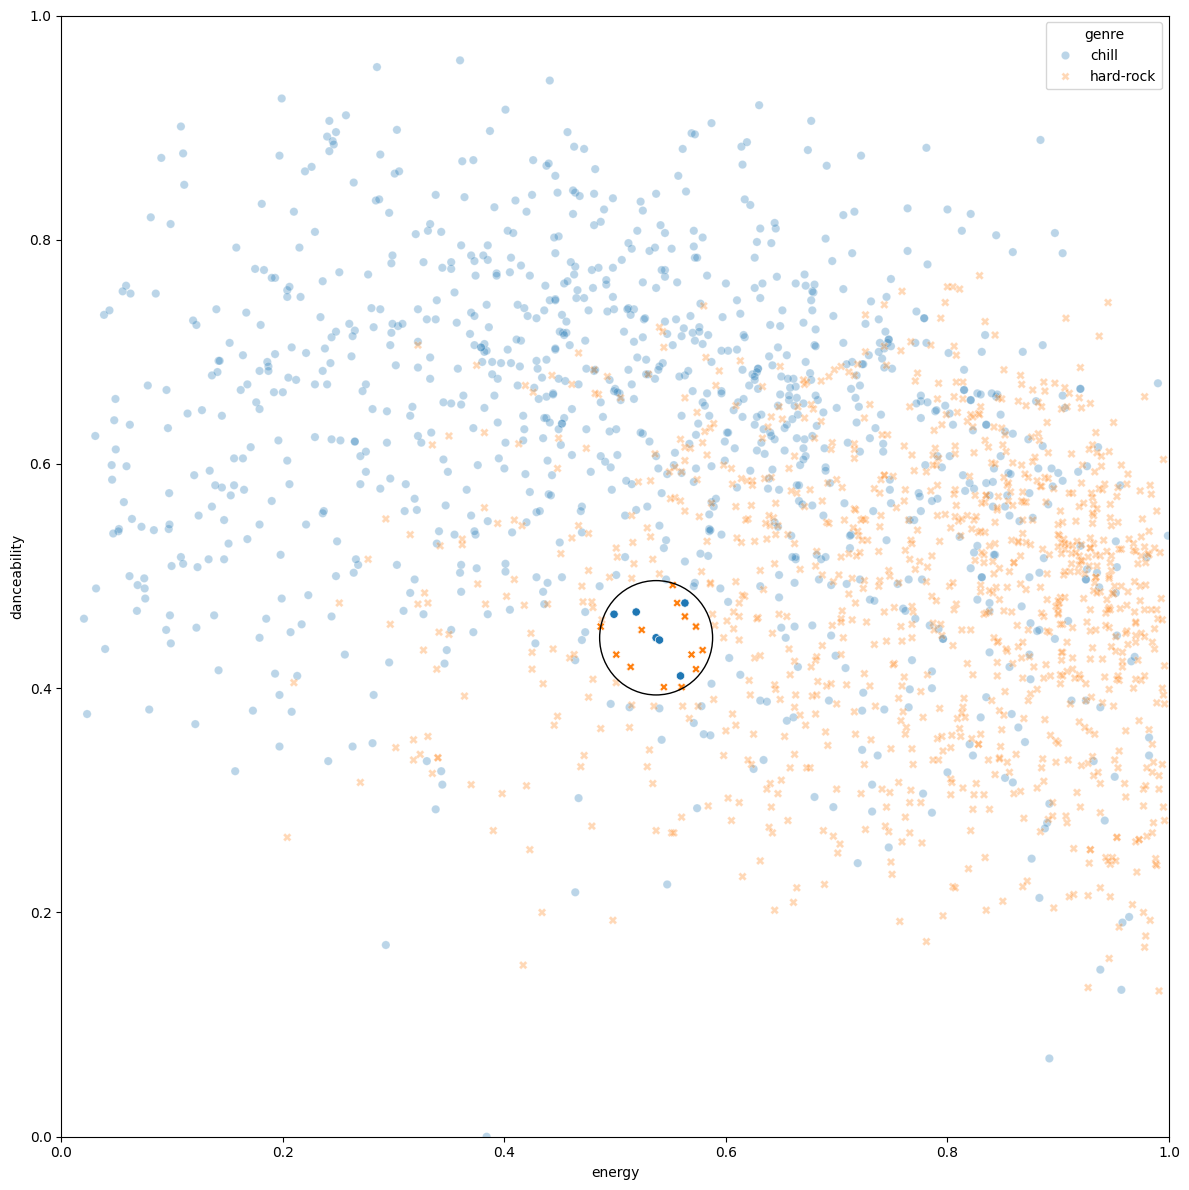

In [6]:
nbrs = knn.kneighbors(newsong)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='energy', y='danceability',
                style='genre',
                hue='genre', data=data, alpha=0.3, ax=ax)
sns.scatterplot(x='energy', y='danceability',
                hue='genre', style='genre',
                data=pd.concat([data.loc[0:0, :], data.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newsong.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

[Text(0.5, 0.8333333333333334, 'danceability <= 0.618\ngini = 0.5\nsamples = 2000\nvalue = [1000, 1000]\nclass = chill'),
 Text(0.25, 0.5, 'energy <= 0.408\ngini = 0.443\nsamples = 1296\nvalue = [430, 866]\nclass = hard-rock'),
 Text(0.125, 0.16666666666666666, 'gini = 0.334\nsamples = 170\nvalue = [134, 36]\nclass = chill'),
 Text(0.375, 0.16666666666666666, 'gini = 0.388\nsamples = 1126\nvalue = [296, 830]\nclass = hard-rock'),
 Text(0.75, 0.5, 'energy <= 0.784\ngini = 0.308\nsamples = 704\nvalue = [570, 134]\nclass = chill'),
 Text(0.625, 0.16666666666666666, 'gini = 0.209\nsamples = 600\nvalue = [529, 71]\nclass = chill'),
 Text(0.875, 0.16666666666666666, 'gini = 0.478\nsamples = 104\nvalue = [41, 63]\nclass = hard-rock')]

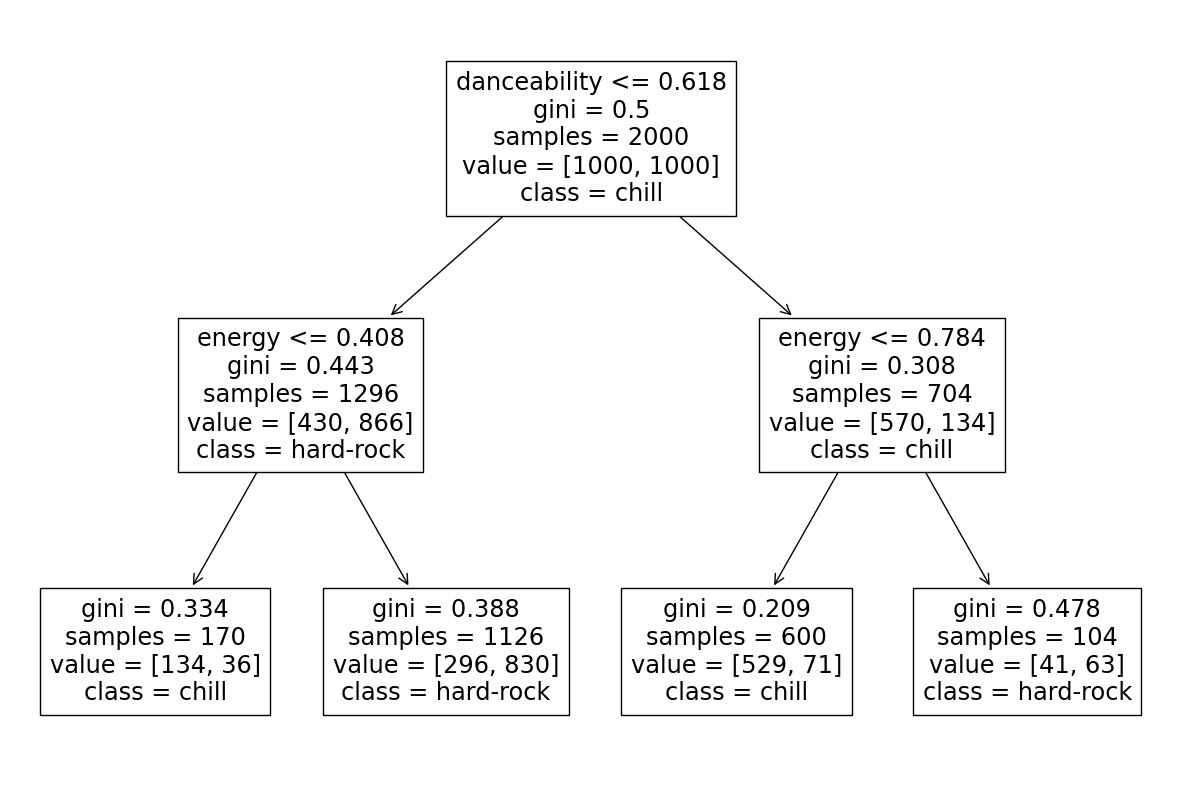

In [13]:
# Tree models (CART)
# Sets of if and elses
# Recursive partitioning -> Data is splited using the predictor values that best separate the data
from sklearn import tree
X = data[predictors]
y = data[target]

fig,ax = plt.subplots(figsize=(15,10))
decision_tree = DecisionTreeClassifier(random_state=1,
                                   min_impurity_decrease=0.003,max_depth=2)
decision_tree.fit(X, y)
tree.plot_tree(decision_tree, feature_names=predictors, class_names=decision_tree.classes_,ax=ax)

Algorithm -> Response variable $y$, set of $P$ predictors variables $X_{j}$ for $j=1...P$

1. For each variable $X_{j}$
   1. For each value $s_{i}$ of $X_{j}$
      1. Split the records in $A$ with $X_{j}$ values $\leq$ $s_{i}$ in one partition, and the others in partition $B$.
      2. Measure the homegeneity of classes within each subpartition of $A$.
   2. Select the value $s_{j}$ that produces the best separation for the variable $X_{j}$
2. Select the variable $X_{j}$ and the cutoff $s_{j}$ that produces maximum within-partition.

Recursive Part 
1. Initialize $A$ as the entire dataset
2. Apply the partitioning algorithm to split $A$ into two subpartitions, $A_{1}$ and $A_{2}$
3. Repeat the algorithm to $A_{1}$ and $A_{2}$
4. The algorithm terminates when no further partitions can be made (or other termination clause)

In [14]:
# Measuring impurity of partition
# Gini -> I(A) = p*(1-p) -> maximized when p = 0.5, minimized when p = 0 or p = 1
# Entropy -> -plog(p) - (1-p)log(1-p)

# Stop tree from growing
# Can achieve 100 acc in training data
# Avoid spliting a partition if too small (min_samples_split=2) and (min_samples_leaf=1)
# Dont split if does not significantly reduce the impurity
# Using grid search and checking for max_depth and min_sample_splits (GridSearchCV)

# Continuous value -> Impurity (Squared deviations from the mean (squared errors))
# Trees can capture non linear relationships
# Self explainable

In [16]:
# Bagging and Random Forest
# Bagging -> Boostraping aggregating -> Wisdom of crowds

- Algorithm 
  1. Initialize M(number of models) and n (number of records, n < N)
  2. Take a boostrap sample of n records from the training data
  3. Train a model on the bootstrap sample


- The bagged estimate of the probabilities is the average of the probabilities of each model

In [17]:
# Random forest 
# Bagging on decision trees 
# Sample records AND sample features
# With random forests, for each tree, the avaiable split points are restricted to a subset of features
# For each tree, take a bootstrap sample of the data.
# For each split decision in the training of a single tree, restrict to only p < P variables.
# Train the tree until its fully grown
# Repeat for the M trees
# The number of samples used in training is approx 63%. -> 1 - (1 - 1/n)^n -> 1 - e^-1 -> 0.63+-s (out-of-bag samples are the 37%)
# Random forest is a blackbox model

In [31]:
X = data[predictors]
y = data[target]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.82681564 0.17318436]
 [0.82777778 0.17222222]
 [0.56756757 0.43243243]
 ...
 [0.02222222 0.97777778]
 [0.19512195 0.80487805]
 [0.40625    0.59375   ]]


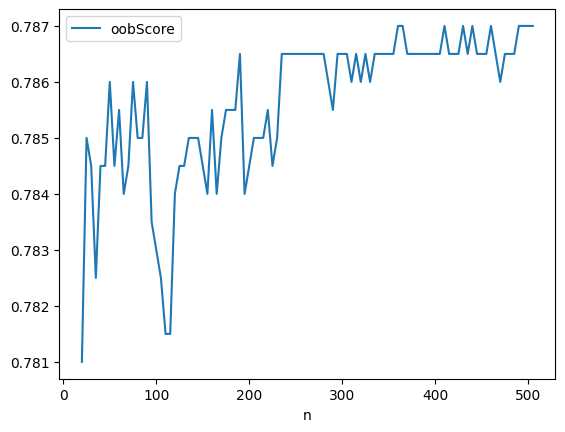

In [32]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

In [33]:
# Variable importance -> Mean decrease in gini(for example) across all splits


In [34]:
# Boosting 
# Requires much more care than bagging
# Series of models, where each model learns on the residual of the one before

- Algorithm (Adaboost)
  - Initialize observation weights to 1/N (N size of data)
  - Train a model that minimizes weighted error $e_{m}$ defined by summing the weights of the misclassified observations
  - Add the model to the ensemble = $F_{m} = F_{m-1} + \alpha_{m}f_{m}$, where $\alpha_{m} = \frac{log1 - e_{m}}{e_{m}}$
  - Update the weights such that the erros are increased for misclassified observations
- The boosted estimate is given by $\sum_{i}^{M}\alpha_{i}f_{i}$


- Gradient boosting -> Fits the model on the *pseudo-residuals*, which has the effect on training more heavily on the larger residuals. Also, samples observations and features at each stage

In [36]:
# XGBoost
X = data[predictors]
y = pd.Series([1 if o == 'chill' else 0 for o in data[target]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [38]:
xgb_df = X.copy()
xgb_df['prediction'] = ['chill' if p == 1 else 'hard-rock' for p in xgb.predict(X)]
xgb_df['prob_hard-rock'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   energy  danceability prediction  prob_hard-rock
0   0.537         0.445      chill        0.114213
1   0.537         0.445      chill        0.114213
2   0.405         0.470      chill        0.160413
3   0.199         0.480      chill        0.015782
4   0.208         0.379      chill        0.048183


In [39]:
# Avoiding overfitting
# eta -> Learning rate 
# suubsample -> Fraction of samples to be selected at each iteration
# Regularization -> L2 and L1
# L2 -> Euclidean norm -> Gaussian prior on the parameters
# L1 -> Manhattan norm -> Laplace prior on the parametrs -> Works as variable selection
# Cross-validation is especially important for boosting due to the large number of hyperparameters that need to be set.

,energy,danceability,prediction,prob_hard-rock
0,0.537,0.445,chill,0.114213
1,0.537,0.445,chill,0.114213
2,0.405,0.470,chill,0.160413
3,0.199,0.480,chill,0.015782
4,0.208,0.379,chill,0.048183
...,...,...,...,...
1995,0.921,0.514,hard-rock,0.930283
1996,0.515,0.554,hard-rock,0.591215
1997,0.914,0.257,hard-rock,0.998009
1998,0.612,0.476,hard-rock,0.924531
